then:
- Simple RV data - eccentricity distribution (long period, stretch goal: mixture model to get short period too)
- RR Lyrae distances, infer P-L relation


TODO:
- 47 Tuc: https://aladin.unistra.fr/AladinLite/?target=00%2024%2014.511-72%2004%2045.58&fov=3.00&survey=CDS%2FP%2FDSS2%2Fcolor
- Proper motion distribution mixture model
- https://gea.esac.esa.int/archive/

- Used to thinking in terms of likelihood and priors, but often the distinction gets blurry

- Commentary:
    - about sampling
    - about mixture models
    

In [1]:
import pathlib

import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import daft
from pyia import GaiaData
import arviz as az
import pymc as pm

# Hierarchical Models

Most of the probabilistic models we have discussed so far have been *one-level* models: In these cases, the data are generated by some functional model that has parameters, and those parameters are random variables assumed to be drawn from fixed prior probability distributions. Hierarchical models are also called *multi-level* models because they take these ideas and expand and generalize them to consider models that may have multiple levels or layers of random variables that generate the data. For example, if we have data $D$ and some parameters $\theta$, in a one-level model the join distribution $p(D, \theta)$ is often factorized as:

$$
p(D, \theta) = p(D | \theta) \, p(\theta)
$$

where $p(D | \theta)$ is the "likelihood" and $p(\theta)$ is the "prior."

In a multi-level model, the parameters closest to the data, $\theta$, are themselves generated by some stochastic process that is governed by another set of random variables or parameters known as "hyper-parameters," sometimes denoted as $\alpha$. In such a case, the joint probability could be factorized as:

$$
p(D, \theta, \alpha) = p(D | \theta) \, p(\theta | \alpha) \, p(\alpha)
$$

Note that in this case (and as is often the case), the data only depends on $\alpha$ through the relationship between $\theta$ and $\alpha$, but this is not a requirement. A graphical model for this (general) case would look like:

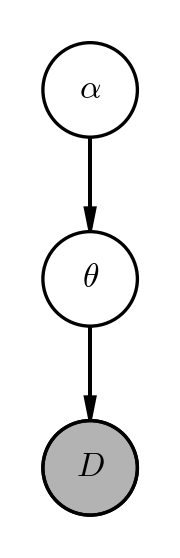

In [2]:
pgm = daft.PGM(dpi=120)

pgm.add_node("data", "$D$", 0, 0, observed=True)
pgm.add_node("theta", r"$\theta$", 0, 1)
pgm.add_node("alpha", r"$\alpha$", 0, 2)

pgm.add_edge("theta", "data")
pgm.add_edge("alpha", "theta")

pgm.render();

In astronomy, you will frequently see "population models" of this form in which the $\theta$ variables are parameters that exist for each object in the population, and the $\alpha$ parameters are parameters of the population distribution — in these cases, using our very general terminology from above, there would be a plate around $\theta$ and $D$: 

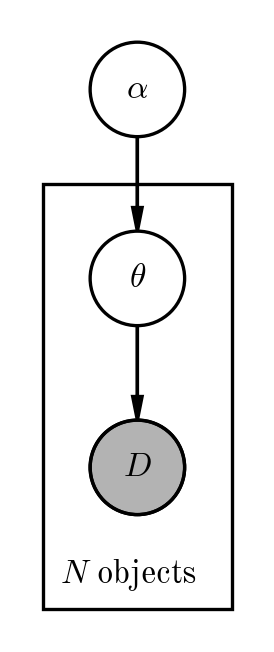

In [3]:
pgm = daft.PGM(dpi=120)

pgm.add_node("data", "$D$", 0, 0, observed=True)
pgm.add_node("theta", r"$\theta$", 0, 1)
pgm.add_node("alpha", r"$\alpha$", 0, 2)

pgm.add_edge("theta", "data")
pgm.add_edge("alpha", "theta")

pgm.add_plate([-0.5, -0.75, 1, 2.25], label="$N$ objects")

pgm.render();

There are many examples of population models like this in the literature, but to name a few that can be thought of as hierarchical population models:
- **Exoplanet (or binary-star) period or eccentricity distribution**: Here the raw data is usually light curves with transits or eclipses, but the parameters one wants to know are the properties of the period distribution or eccentricity distribution of the systems. A model therefore has the true period/eccentricity for each system, but then some parameters that govern the distribution of periods/eccentricities.
- **Velocity dispersion of a galaxy cluster**: Here the observed data are redshifts of members of a galaxy cluster, but one wants to know the velocity dispersion of the cluster. One way of doing this inference would be to construct a hierarchical model that predicts redshifts given the mean velocity and dispersion of a galaxy cluster by simulaneously inferring the true velocity of each member galaxy given its (noisy) redshift measurement.
- **Color–magnitude fitting / stellar population modeling**: The observed data here are the magnitudes of stars in a number of photometric bands, and maybe also spectroscopic parameters, and the parameters one wants to infer are properties of the stellar population like the distribution of ages, metallicities, and stellar evolutionary stages.

*Note: Implementations of and solutions to these types of inference problems aren't always expressed as hierarchical models because of computational limitations or because there are other ways of simplifying the models.*

One simple example of a hierarchical model was introduced at the end of the Probabilistic Graphical Models (PGMs) notebook — let's return to this example in more detail and demonstrate an implementation of this model.


## Example: The mean distance of a (simulated) star cluster

Returning to the example we saw at the end of the Probabilistic Graphical Model (PGM) tutorial, to recap: We are given measurements of the parallaxes (and uncertainties) for a collection of stars that we are confident are members of a star cluster, and we want to infer the mean distance to and size of the star cluster as modeled as a Gaussian. 

Let's start by generating a simulated dataset that matches this problem setup:

In [30]:
rng = np.random.default_rng(seed=42)
N = 256

sim_data = at.QTable()

# we generate the true distances from a Gaussian and convert to parallax values:
true_sc_dist = 500 * u.pc
true_sc_std = 8.7 * u.pc
true_sc_star_dist = rng.normal(true_sc_dist.value, true_sc_std.value, size=N) * true_sc_dist.unit
sim_data["parallax"] = true_sc_star_dist.to(u.mas, u.parallax())

# heteroscedastic noise (i.e. each star has its own error bar):
sim_data["parallax_error"] = (10 ** rng.uniform(-2, -1.0, size=N)) * u.mas

# now we have to "observe" the true parallaxes with the generated uncertainties:
sim_data["parallax"] = (
    rng.normal(sim_data["parallax"].value, sim_data["parallax_error"].value)
    * sim_data["parallax"].unit
)

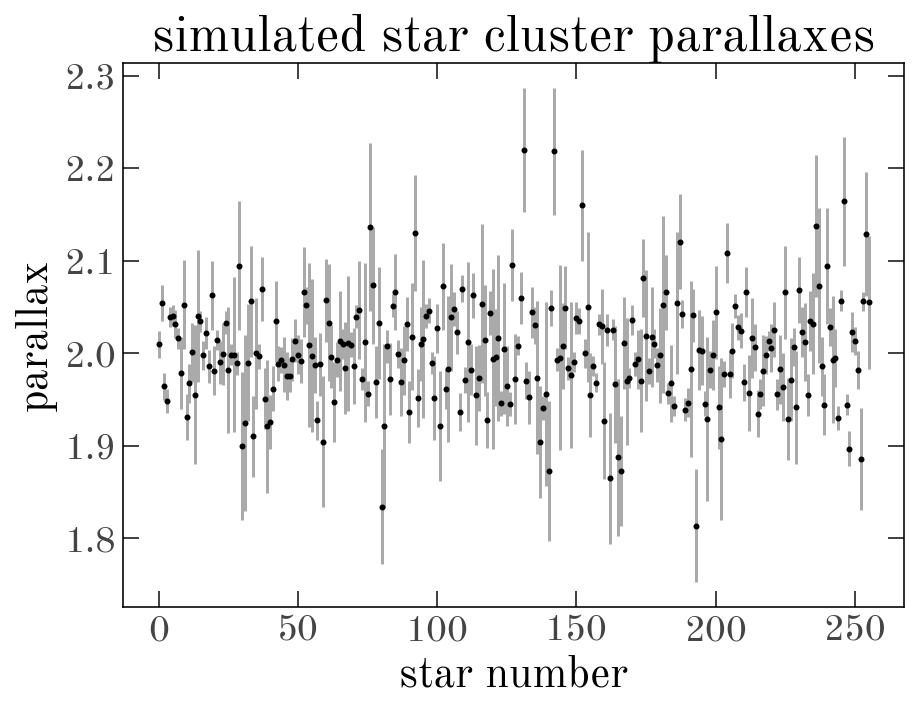

In [6]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    np.arange(len(sim_data)),
    sim_data["parallax"].value,
    yerr=sim_data["parallax_error"].value,
    ls="none",
    marker="o",
    markersize=3,
    ecolor="#aaa",
)
plt.title("simulated star cluster parallaxes")
plt.xlabel("star number")
plt.ylabel("parallax");

We now have measurements of parallaxes $\varpi_n$ for $N=256$ stars and values of the parallax uncertainty $\sigma_{\varpi, n}$ for these stars. We would like to infer the mean distance $\mu_r$ to these stars and the intrinsic size $\sigma_r$ of the star cluster, but to do this we have to also infer the true distances $r_n$ for every star in the cluster. (For notational tidiness below, let's define $\boldsymbol{r} = \{r_n\}_N$ and $\boldsymbol{\varpi} = \{\varpi_n\}_N$ to represent the sets of true distances and observed parallaxes, respectively) The thing we are ultimately after in this problem setup is the *marginal posterior pdf* for $\mu_r, \sigma_r$ given the data, or, in terms of probability distributions:

$$
p(\mu_r, \sigma_r | \boldsymbol{\varpi})
$$

But how do we get to this object? Let's start by writing down the full joint distribution for all parameters (unknown random variables) and data in our model:

$$
p(\mu_r, \sigma_r, \boldsymbol{r}, \boldsymbol{\varpi})
$$

How can we factorize this joint pdf to get to the marginal posterior pdf that we need? We can figure that out by writing down a PGM! 

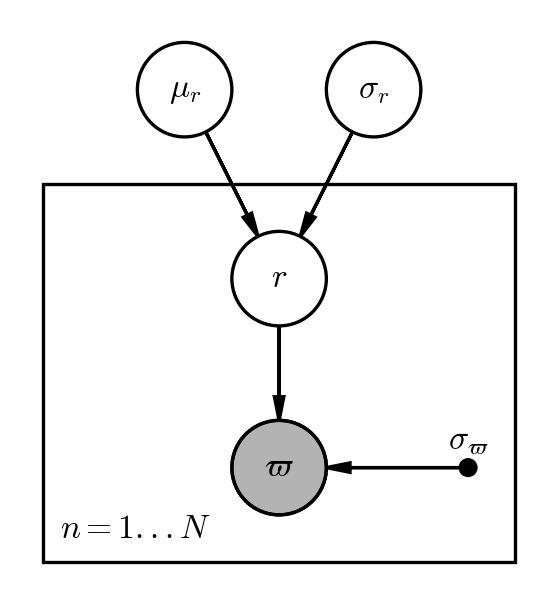

In [7]:
pgm = daft.PGM(dpi=120)

pgm.add_node("plx", r"$\varpi$", 0, 0, observed=True)
pgm.add_node("r", "$r$", 0, 1)
pgm.add_node("mu", r"$\mu_r$", -0.5, 2)
pgm.add_node("std", r"$\sigma_r$", 0.5, 2)
pgm.add_node("err", r"$\sigma_\varpi$", 1, 0, fixed=True)


pgm.add_edge("r", "plx")
pgm.add_edge("mu", "r")
pgm.add_edge("std", "r")
pgm.add_edge("err", "plx")

pgm.add_plate([-1.25, -0.5, 2.5, 2], label=r"$n = 1...N$", position="bottom left")

pgm.render();

The relationships between the random variables in the PGM above tell us that we can write:

$$
p\left(\mu_r, \sigma_r, \boldsymbol{r}, \boldsymbol{\varpi} \right) = 
    \left[ \prod_n^N p(\varpi_n | r_n) \, p(r_n | \mu_r, \sigma_r) \right] p(\mu_r) \, p(\sigma_r)
$$

In probability calculus, factorization is symmetric: We could equally well have factorized this to read

$$
p\left(\mu_r, \sigma_r, \boldsymbol{r}, \boldsymbol{\varpi}\right) = 
    p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi}) \, p(\boldsymbol{\varpi}) \quad .
$$

This factorization gets us closer to the thing we want in that $p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi})$ is a posterior pdf over all of the parameters of the model given the data.

The distribution we want is a *marginal* posterior pdf $p(\mu_r, \sigma_r | \boldsymbol{\varpi})$ because some parameters have been *marginalized out* (i.e. integrated over): the per-star true distances $\boldsymbol{r} = r_n$:

$$
p(\mu_r, \sigma_r | \boldsymbol{\varpi}) = \int \textrm{d}\boldsymbol{r} \, p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi})
$$

From setting the two factorizations above equal to one another (exactly the same way you may have used Bayes' rule), we can get the expression:

$$
p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi}) \propto
    \left[ \prod_n^N p(\varpi_n | r_n) \, p(r_n | \mu_r, \sigma_r) \right] p(\mu_r) \, p(\sigma_r)
$$

How will we integrate this expression over the $\boldsymbol{r}$'s to get to the marginal posterior pdf we want?

In some cases, it is possible to analytically marginalize (integrate) out per-object parameters. For example, if the relationship between the $r$'s and our data was linear, it would be possible to do the integral above and produce a closed-form expression that removes the hierarchical nature of this model. In this example, however, the parallax is the inverse of the distance, so the integral is not straightforward.

Instead, here we will use Markov Chain Monte Carlo (MCMC) to help with the marginalization. It turns out that if we use MCMC to generate samples from the full posterior pdf $p(\mu_r, \sigma_r, \boldsymbol{r} | \boldsymbol{\varpi})$, and simply take the parameter chains for $\mu_r, \sigma_r$, these will be equivalent to samples of the parameters from the marginal posterior pdf $p(\mu_r, \sigma_r | \boldsymbol{\varpi})$. This is one of the most powerful aspects of MCMC!

Let's construct a model with [pymc](https://pymc.io) to do this MCMC sampling. To do this, we will need to specify (hyper)prior pdfs for $\mu_r$ and $\sigma_r$. 
- $\mu_r$: We will use a broad, truncated normal distribution with a mean of 1 kpc, a standard deviation of 2 kpc, and a minimum value of 0 (distances have to be positive!). This is a totally arbitrary choice for this example, but the idea is to be broad prior with a slight preference toward 1 kpc.
- $\sigma_r$: Here we will sample in $\ln{\sigma_r}$ and use a uniform prior on this transformed parameter, which is equivalent to putting a prior on $\sigma_r$ such that $p(\sigma_r) \propto \sigma_r^{-1}$ (this is known as a [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) for the standard deviation of a Gaussian). 

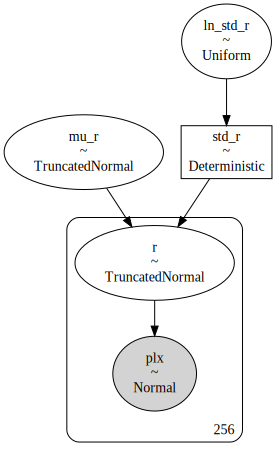

In [8]:
with pm.Model() as plx_model:
    # This is the (hyper)prior on the mean distance to the star cluster. Let's assume 
    # that we have some prior knowledge about the distance to this cluster, and so we 
    # set a broad normal distribution prior on its distance. However, we know that 
    # distances can't be negative, so we use a truncated normal distribution (truncated 
    # to values > 0) instead:
    mu_r = pm.TruncatedNormal("mu_r", mu=1.0, sigma=2.0, lower=0, upper=np.inf)
    
    # This is the (hyper)prior on ln(sigma), the log of the standard deviation of the 
    # star cluster's distance (i.e. the physical size of the cluster along the line of 
    # sight).
    ln_std_r = pm.Uniform("ln_std_r", -8, 0)
    
    # We will sample over ln(sigma), but we need the value of sigma (standard deviation)
    # to plug into the model we use for the cluster. We can transform the parameter to
    # a new un-logged value, but we need to tell pymc that this is not a new random 
    # variable: the relationship between these parameters is a deterministic tranform
    std_r = pm.Deterministic("std_r", pm.math.exp(ln_std_r))
    
    # With parameters to represent the cluster mean distance and standard deviation,
    # we can now define the model for the distances to each star. Here we will again use
    # a truncated normal distribution (r>=0). Note that we specify the "shape" of this 
    # parameter: This tells pymc to expect that we will have as many parameter values 
    # as we have len(sim_data). 
    # This line is equivalent to p(r | mu_r, sigma_r) in the math above
    r = pm.TruncatedNormal("r", mu_r, std_r, shape=len(sim_data), lower=0, upper=np.inf)
    
    # Finally, with the model-predicted individual stellar distances, we need to define
    # the relationship between our model and our data (i.e. the parallax measurements).
    # We assume that our parallax uncertainties are Gaussian, so we set up another 
    # Normal distribution (not truncated) with an expression for the model predicted 
    # parallaxes (1/r), and pass in the observed parallaxes with the "observed" keyword.
    # This line is equivalent to p(parallax | r) in the math above:
    pm.Normal(
        "plx",
        1 / r,
        observed=sim_data["parallax"].to_value(u.mas),
        sigma=sim_data["parallax_error"].to_value(u.mas),
    )
    
# Let's visualize the graphical model for this model and compare to the one above:
pm.model_to_graphviz(plx_model)

Overall, this has the same structure as the PGM we drew above! This model explicitly notes the distributions at each vertex (parameter) or when a relationship is deterministic, but otherwise this is equivalent to our PGM.

We will now fire up the `pymc` sampler to generate posterior samples of all of our parameters. When the number of parameters is large, it can be useful to start the sampler with a good initial guess for the parameter values. Of course, when working with real data, you don't know the true values used to simulate the data :), so we won't start from the true values. Here, let's initialize the distances to each star set to the inverse-variance weighted parallax of the stars:

In [11]:
inv_var = 1 / sim_data["parallax_error"] ** 2
est_mean_plx = np.sum(sim_data["parallax"] * inv_var) / np.sum(inv_var)
est_mean_r = est_mean_plx.to_value(u.kpc, u.parallax())

With these initial values in hand, we can run the sampler:

In [13]:
with plx_model:
    samples = pm.sample(
        tune=2000,
        draws=1000,
        initvals={
            "mu_r": est_mean_r,
            "ln_std_r": -3.0,
            "r": np.full(len(sim_data), est_mean_r),
        },
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_r, ln_std_r, r]


/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.


*pymc may output some warnings above — you can ignore these!*

The first thing I like to check after running a pymc sampling is to use [arviz](https://python.arviz.org/en/latest/) to output a summary of sampling statistics for the run. Here we have a lot of parameters (the full vector of $r$ values is >3000 parameters!), so I will restrict the summary output to only include the hierarchical parameters:

In [22]:
# the "~r" below means "not r"
az.summary(samples, var_names=['~r'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_r,0.500,0.001,0.499,0.502,0.000,0.000,5481.0,2781.0,1.0
ln_std_r,-4.787,0.077,-4.932,-4.642,0.002,0.001,1719.0,2186.0,1.0
std_r,0.008,0.001,0.007,0.010,0.000,0.000,1719.0,2186.0,1.0


There is a lot to unpack here, but these are all useful statistics computed from the samples that allow us to assess whether the sampling was successful. The first two columns show the mean and standard deviation (sd) of the parameter value, and the following two show the "highest density interval" values (this is one version of a *credible region* estimated from the posterior samples). We won't talk about the next few columns, but MCSE is short for "Monte Carlo Standard Error" and ESS is short for "Effective Sample Size." These are both important diagnostics for assessing the quality of the samples returned. The final column `r_hat` (in math, $\hat{R}$) is the Gelman–Rubin convergence statistic (which you generally want to be fairly close to 1). Some more information about convergence diagnostics is available [in this book chapter](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html) or [this coursera course](https://www.coursera.org/lecture/introduction-to-pymc3/autocorrelation-and-effective-sample-size-YSW3x).

By the way, we could show just a few of the $r$ values by making a selection with the `coords` argument, for example, to show the first 5 values of $r$:

In [23]:
az.summary(samples, coords={"r_dim_0": np.arange(5)})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_r,0.500,0.001,0.499,0.502,0.000,0.000,5481.0,2781.0,1.0
ln_std_r,-4.787,0.077,-4.932,-4.642,0.002,0.001,1719.0,2186.0,1.0
r[0],0.498,0.003,0.492,0.504,0.000,0.000,8854.0,2329.0,1.0
r[1],0.490,0.004,0.482,0.497,0.000,0.000,6032.0,2594.0,1.0
r[2],0.508,0.003,0.501,0.514,0.000,0.000,7436.0,2799.0,1.0
r[3],0.511,0.003,0.506,0.517,0.000,0.000,6712.0,2448.0,1.0
r[4],0.491,0.002,0.486,0.495,0.000,0.000,6313.0,2666.0,1.0
std_r,0.008,0.001,0.007,0.010,0.000,0.000,1719.0,2186.0,1.0


These all look great: `r_hat` is essentially 1.0 for all parameters, and the effective sample size is over 1000.

After doing a quick check of the sampling summary statistics, I next like to make a "corner" plot to visualize 2D projections of the posterior pdf estimated from the samples. With `arviz`, we can make a corner plot using the `plot_pair()` function. Here, I've changed some default values and added in the true values of the parameters as a red marker for comparison:

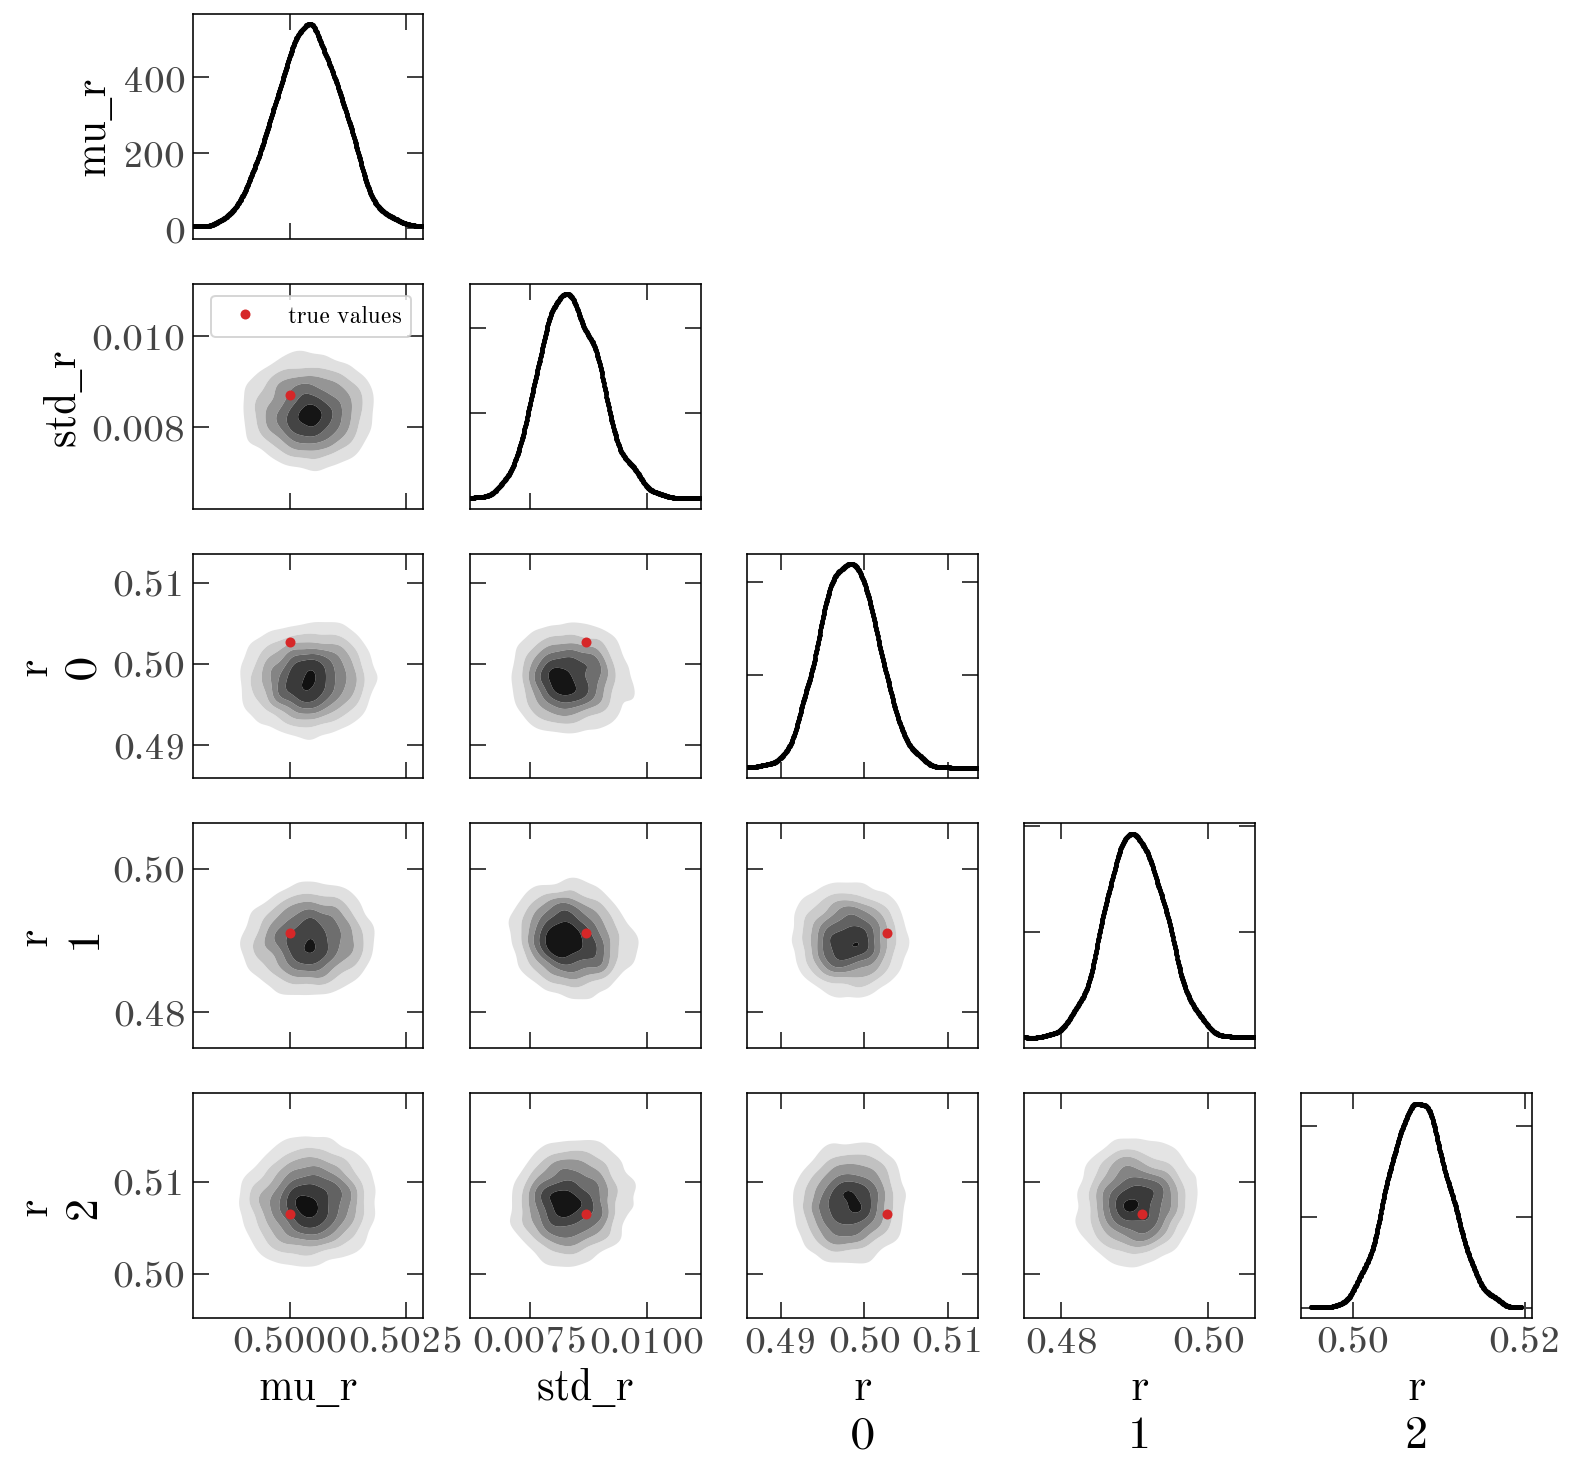

In [42]:
axes = az.plot_pair(
    samples,
    var_names=["mu_r", "std_r", "r"],
    marginals=True,
    kind="kde",
    kde_kwargs=dict(contourf_kwargs=dict(cmap="Greys"), contour_kwargs=dict(alpha=0.0)),
    figsize=(12, 12),
    reference_values={
        "mu_r": true_sc_dist.to_value(u.kpc),
        "std_r": true_sc_std.to_value(u.kpc),
        "r 0": true_sc_star_dist.to_value(u.kpc)[0],
        "r 1": true_sc_star_dist.to_value(u.kpc)[1],
        "r 2": true_sc_star_dist.to_value(u.kpc)[2]
    },
    reference_values_kwargs=dict(
        color="tab:red", markersize=5, label="true values", linestyle="none"
    ),
    coords={"r_dim_0": np.arange(3)}
)
axes[1, 0].legend(fontsize=12);

It looks like our model and sampling produces a posterior pdf that is consistent with the true values, so let's call that a success!

## Problem: Inferring the period distribution of low eccentricity binary stars

We are now going to move on to another demonstration of a hierarchical model with a little more complexity, using real data from the [APOGEE survey](https://www.sdss.org/dr17/), and you will do some of the implementation below.

The setup of this problem is that we would like to infer the (log)period distribution for low-eccentricity, close (short-period) binary-star systems given observations of radial velocities. These are all "SB1" systems, meaning that we assume that the spectra and radial velocity measurements correspond only to the primary star (i.e. the more luminous star) in the system. This is a common case when the primary is slightly evolved, or when the companion is a low-mass star — in these cases, the secondary star contributes negligibly to the spectra. 

### The data

The data are radial velocities $v_r$ measured at times $t$ (represented as JD's) and velocity uncertainties $\sigma_v$ from an updated catalog of binary-star systems produced as a follow-up to [Price-Whelan et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...895....2P/abstract). The dataset contains 14 unique sources, but 321 total velocity measurements (there are >12 velocity measurements per system). The times are given as Julian Date values (JD), and the velocities and uncertainties are given in km/s.

Let's load the data and make some initial visualizations:

In [64]:
apogee_data = at.Table.read('apogee-binaries.fits')
apogee_data[:3]

APOGEE_ID,JD,VHELIO,VHELIO_ERR
bytes23,float64,float64,float64
2M01282954+8522331,2456654.55454,-76.50619786631587,0.07986770702933901
2M01282954+8522331,2458060.74255,-68.47438403977931,0.08288388621975172
2M01282954+8522331,2456902.67954,-61.31942096050062,0.09631454554125078


As mentioned above, in the table, we have 14 unique systems, each with >12 radial velocity measurements:

In [72]:
uniq_ap_ids = np.unique(apogee_data['APOGEE_ID'])
len(uniq_ap_ids)

14

Let's visualize the velocity data:

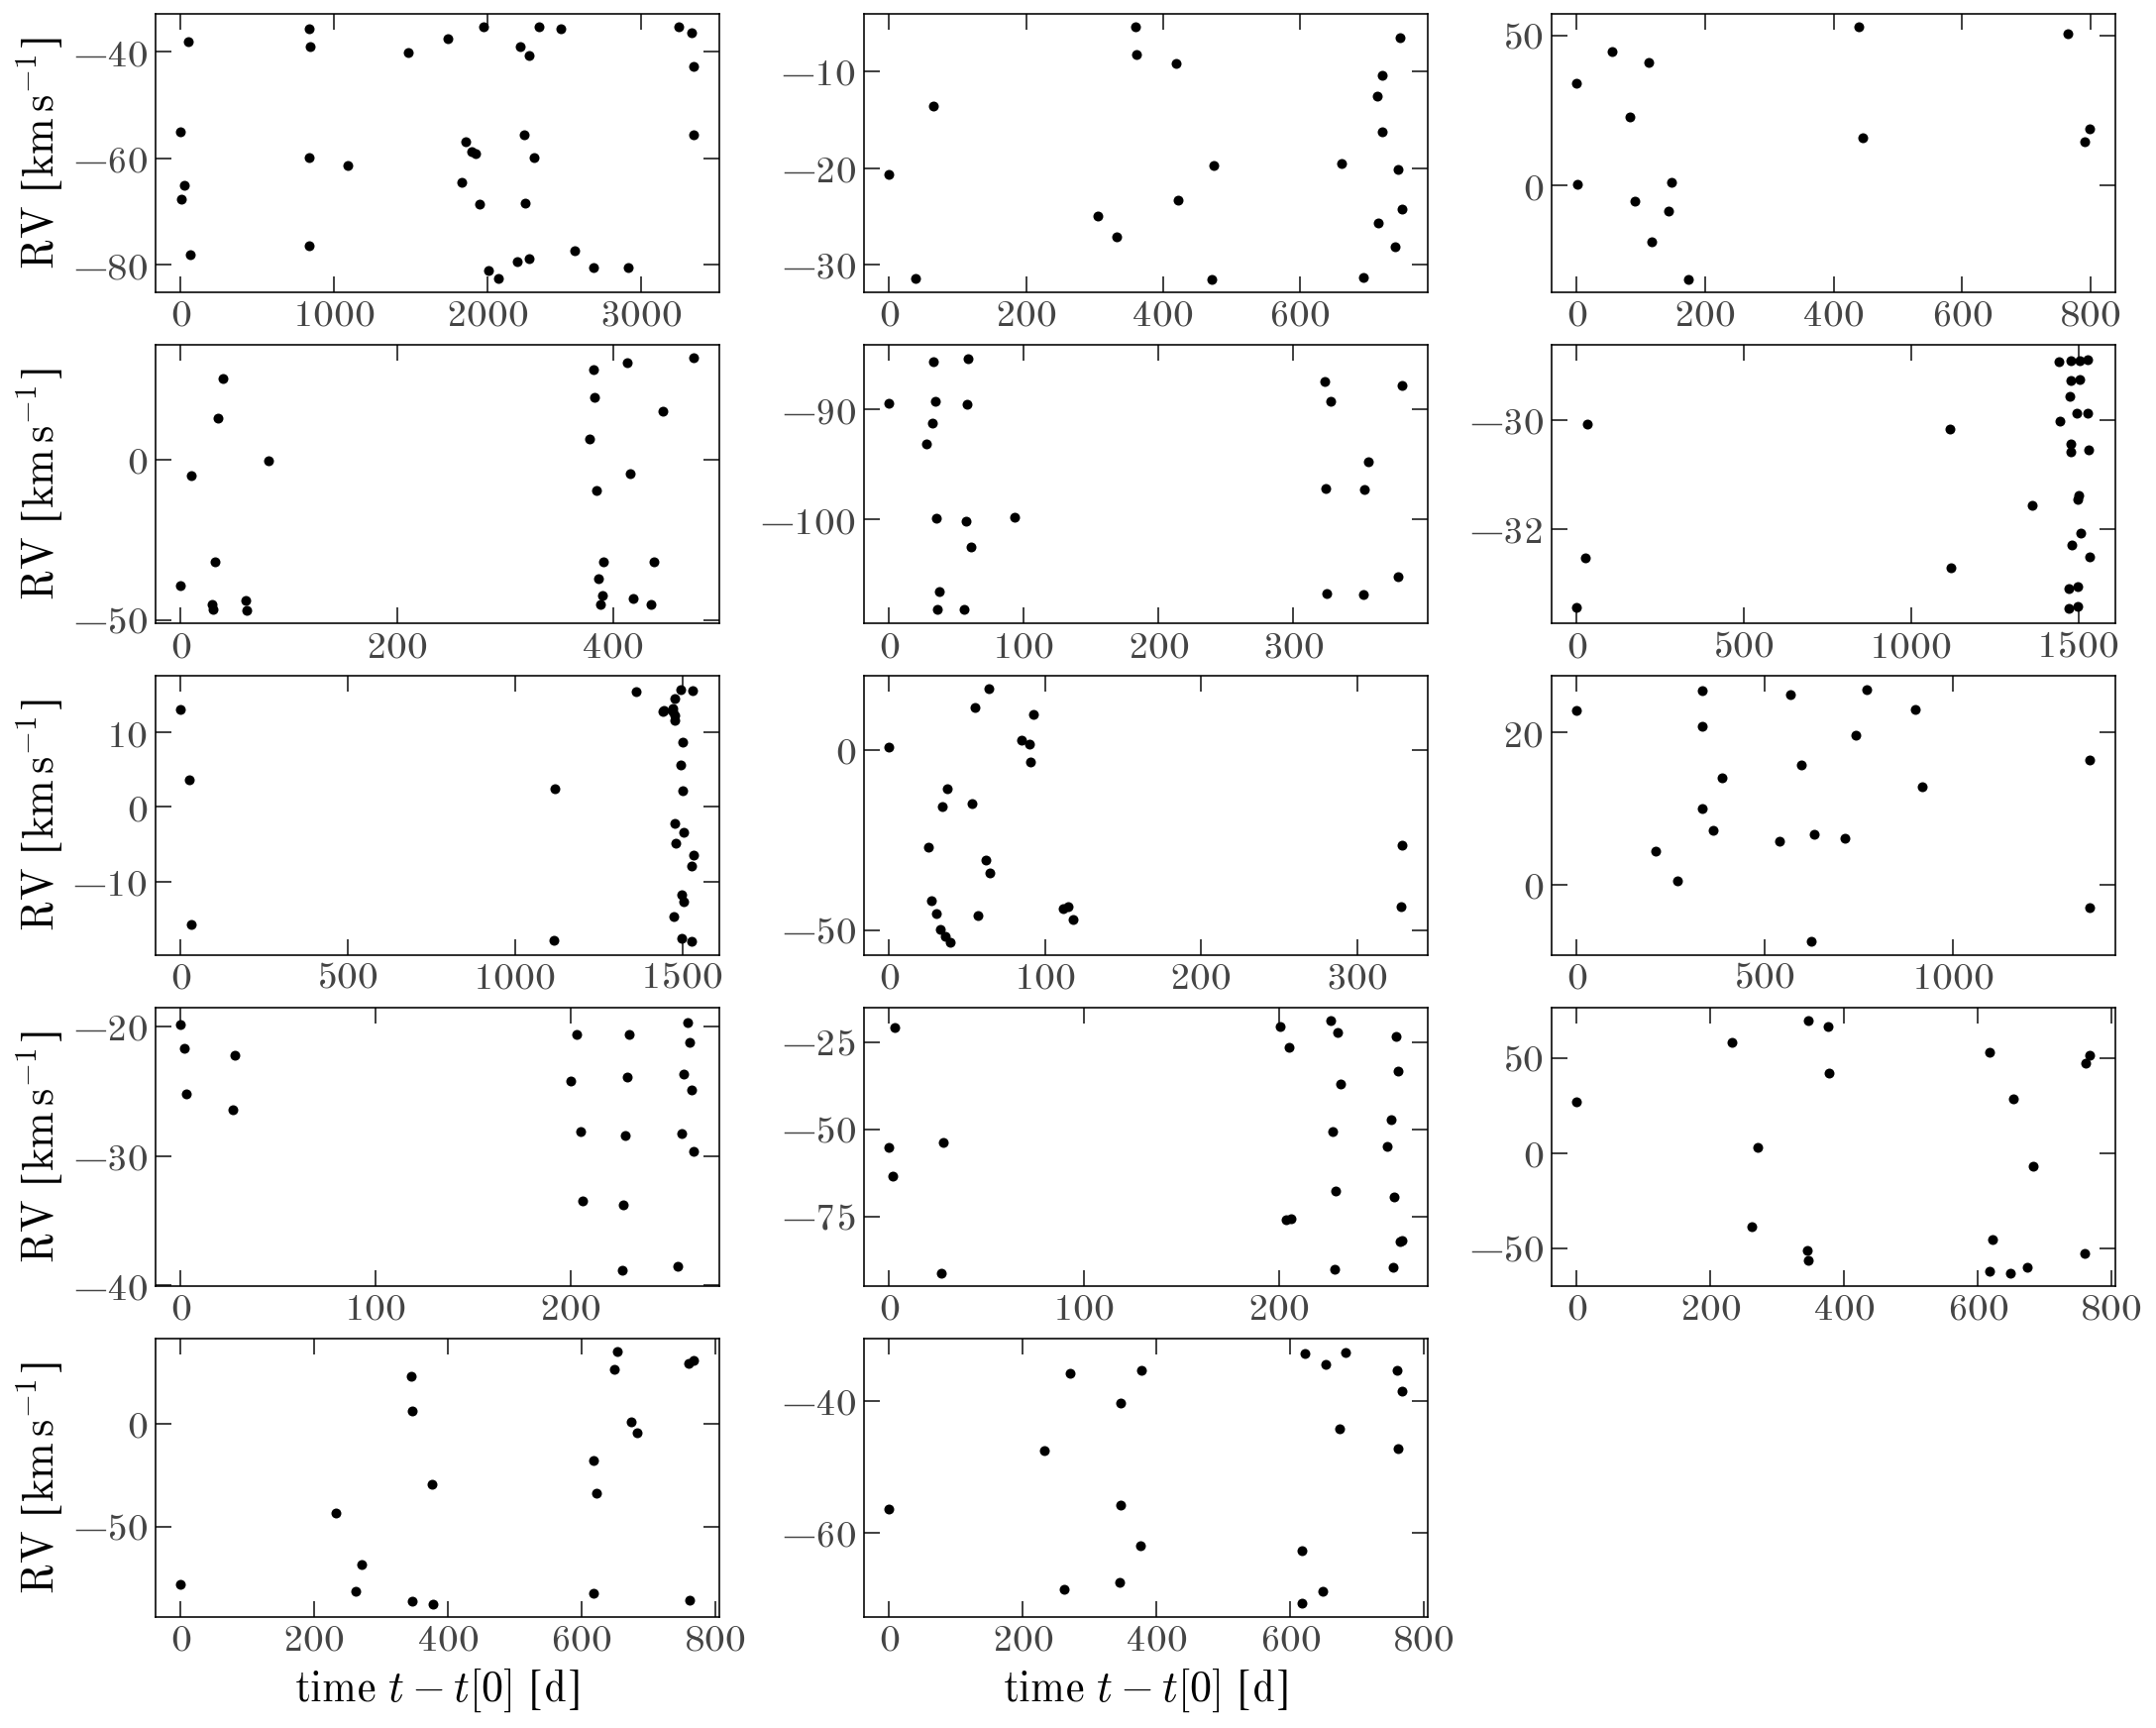

In [86]:
fig, axes = plt.subplots(5, 3, figsize=(15, 12), constrained_layout=True)

for ap_id, ax in zip(uniq_ap_ids, axes.flat):
    one_star_data = apogee_data[apogee_data['APOGEE_ID'] == ap_id]
    ax.errorbar(
        one_star_data['JD'] - one_star_data['JD'].min(),
        one_star_data['VHELIO'],
        one_star_data['VHELIO_ERR'],
        marker='o',
        ls='none'
    )
axes.flat[-1].set_visible(False)
    
for ax in axes[-1]:
    ax.set_xlabel('time $t - t[0]$ [d]')
for ax in axes[:, 0]:
    ax.set_ylabel(f'RV [{u.km/u.s:latex_inline}]');

Those all look like radial velocity-variable sources, but we will clearly need to do some modeling to determine the periods of these systems!

### Part 1: Infer the period of a single system

As a warm-up, let's start with a single system and construct a model to infer the orbital period.

Let's get the data for one of the objects from above, such as the first source:

In [87]:
one_star_data = apogee_data[apogee_data['APOGEE_ID'] == uniq_ap_ids[0]]
len(one_star_data)

36

This source has 36 velocity measurements, and the velocity data is already plotted in the upper left panel of the figure above. What model should we use to measure the period of the orbit? In general, when modeling radial velocity curves from two-body systems (e.g., star–star or star–planet systems), we should use Keplerian dynamics to construct a proper model for the radial velocity given period, eccentricity, and etc. (for example, using the [exoplanet](https://docs.exoplanet.codes/en/latest/) package or [thejoker](https://thejoker.rtfd.io/)). However, in this case, we have prior knowledge that these systems all have negligible eccentricities (i.e. very close to 0): Under this assumption, a good model for the velocities is a sinusoid with an overall offset (the mean velocity). With this setup, we have two choices:
1. We could fit a model like $v_r = a \, \cos\left(\frac{2\pi \, t}{P} + \phi \right) + v_0$, where $a$ is the amplitude, $P$ is the period, $\phi$ is a phase offset, and $v_0$ is the mean (systemic) velocity.
2. Equivalently, we could fit a model $v_r = a \, \cos\left(\frac{2\pi \, t}{P}\right) + b \, \sin\left(\frac{2\pi \, t}{P}\right) + v_0$, where $a$ and $b$ are amplitudes and all other parameters are the same.
These two models are different parametrizations of the same physical model for the data, so how should we pick between them?

**TODO: comments about parametrization**

$$
p(a, b, P, v_0 | \{v_r\}_J) \propto
    \left[ \prod_j^J p(v_r^{(j)} \,|\, a, b, P, v_0) \right] p(a) \,p(b) \,p(P) \, p(v_0)
$$

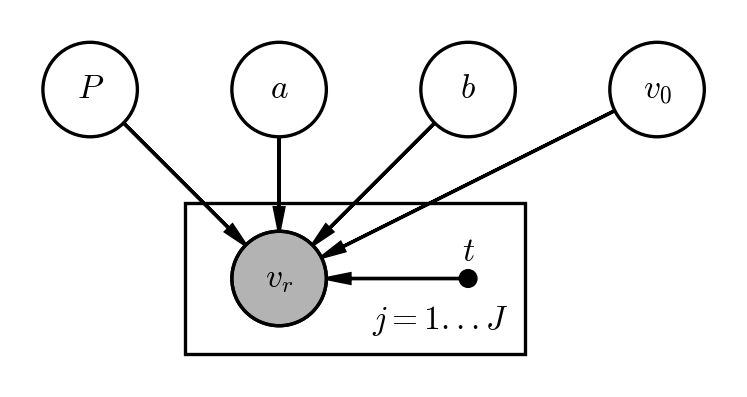

In [60]:
pgm = daft.PGM(dpi=120)

pgm.add_node("RV", r"$v_r$", 0, 0, observed=True)
pgm.add_node("t", r"$t$", 1, 0, fixed=True)

pgm.add_node("P", "$P$", -1, 1)
pgm.add_node("a", "$a$", 0, 1)
pgm.add_node("b", "$b$", 1, 1)
pgm.add_node("v_0", "$v_0$", 2, 1)

pgm.add_edge("P", "RV")
pgm.add_edge("a", "RV")
pgm.add_edge("b", "RV")
pgm.add_edge("v_0", "RV")
pgm.add_edge("t", "RV")

pgm.add_plate([-0.5, -0.4, 1.8, 0.8], label=r"$j = 1...J$", position="bottom right")

pgm.render();

In [88]:
t = one_star_data['JD'] - one_star_data['JD'].min()
rv = one_star_data['VHELIO']
rv_err = one_star_data['VHELIO_ERR']

TODO: Use lomb scargle to initialize ...

In [95]:
from astropy.timeseries import LombScargle

ls = LombScargle(t * u.day, rv, rv_err)

freq, power = ls.autopower(
    minimum_frequency=1/(20 * u.day), 
    maximum_frequency=1/(1.5 * u.day),
    samples_per_peak=10
)
init_P = 1 / freq[power.argmax()]

In [96]:
# SOLUTION:
with pm.Model() as model1:
    P = pm.Uniform('P', 0.1, 20)
    ln_a = pm.Normal('ln_a', 3, 3)
    ln_b = pm.Normal('ln_b', 3, 3)
    v0 = pm.Normal('v0', 0, 150)
    
    a = pm.math.exp(ln_a)
    b = pm.math.exp(ln_b)
    
    model_vr = pm.Deterministic(
        'vr',
        a * pm.math.cos(2*np.pi * t / P) + b * pm.math.sin(2*np.pi * t / P) + v0
    )
    
    pm.Normal(
        'likelihood', 
        model_vr,
        observed=rv,
        sigma=rv_err
    )
    
    samples = pm.sample(
        initvals={
            'P': init_P
        }
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P, ln_a, ln_b, v0]


/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9154, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probabili

### Part 2: Infer the log-period distribution

TODO: Use lomb scargle to initialize all ...

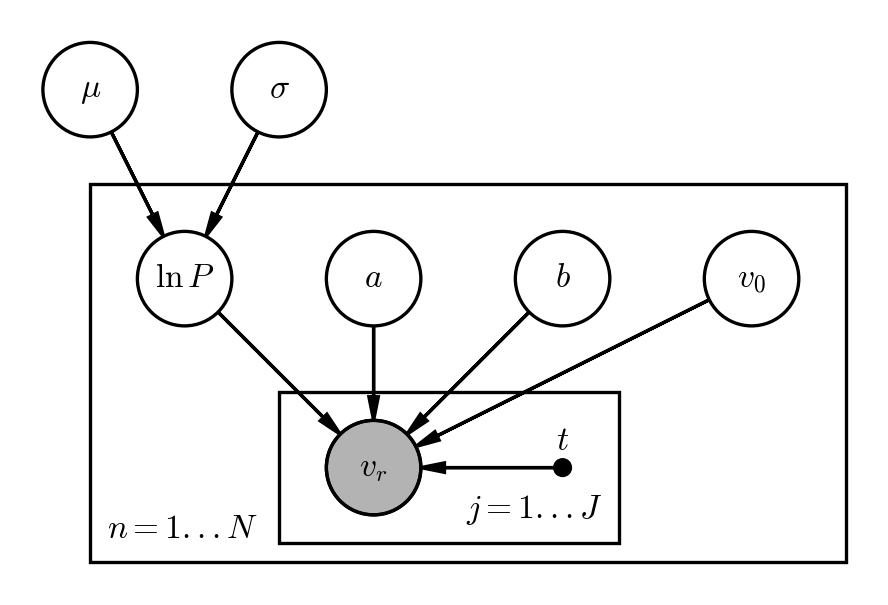

In [57]:
pgm = daft.PGM(dpi=120)

pgm.add_node("RV", r"$v_r$", 0, 0, observed=True)
pgm.add_node("t", r"$t$", 1, 0, fixed=True)

pgm.add_node("lnP", "$\ln P$", -1, 1)
pgm.add_node("a", "$a$", 0, 1)
pgm.add_node("b", "$b$", 1, 1)
pgm.add_node("v_0", "$v_0$", 2, 1)

pgm.add_node("mu", r"$\mu$", -1.5, 2)
pgm.add_node("std", r"$\sigma$", -0.5, 2)

pgm.add_edge("lnP", "RV")
pgm.add_edge("a", "RV")
pgm.add_edge("b", "RV")
pgm.add_edge("v_0", "RV")
pgm.add_edge("t", "RV")
pgm.add_edge("mu", "lnP")
pgm.add_edge("std", "lnP")

pgm.add_plate([-1.5, -0.5, 4, 2], label=r"$n = 1...N$", position="bottom left")
pgm.add_plate([-0.5, -0.4, 1.8, 0.8], label=r"$j = 1...J$", position="bottom right")

pgm.render();

# Mixture models

In the examples above, our models have assumed that all of the objects we observe are true members of the population we want to model (e.g., star cluster). In astronomy, we very rarely have this luxury: We typically have a complex superposition of multiple structures, or at least two components corresponding to an object of interest and the "field" or "background" population of objects. Another (similar) context in which a model like the one implemented above would not be sufficient is when there are outliers in a dataset. For these contexts, the model we wrote down and explored above is too simplistic to be useful for many real-world applications.

One way of handling real datasets that contain objects from different populations or outliers is to use a *mixture model*. Because of how many problems have this structure, I personally think that mixture models are one of the most important tools to know as a data-oriented astronomer. Let's first talk about the fundamentals of mixture models and then explore an example of using a mixture model to measure the distance to a star cluster using Gaia data. (Another resource and good introduction is [Dan F-M's tutorial](https://dfm.io/posts/mixture-models/))

## Fundamentals

In the models we have looked at so far, any parameter or variable is either drawn from a single distribution (e.g., a single normal distribution in many cases above) or is deterministically related to another variable (e.g., distance and parallax). However, this does not have to be the case: the underlying density distribution of a random variable could instead be a more complex thing, such as a mixture of multiple component distributions that each have their own parameters. 

A common and important example used in statistics and machine learning applications is the *Gaussian Mixture Model* (GMM), in which the probability density $p(x | \boldsymbol{\theta})$ of some variable $x$ given parameters $\boldsymbol{\theta}$ is a sum of Gaussians each with a weight $w$. For example, for $K$ Gaussians, the GMM density would be:

$$
p(x | \boldsymbol{\mu}, \boldsymbol{\sigma}) = 
    \sum_k^K w_k \, \mathcal{N}(x | \mu_k, \sigma_k)
$$

where $\sum_k^K w_k = 1$, and $\boldsymbol{\mu} = (\mu_1, \mu_2, ..., \mu_k)$. With the constraint on the sum of the weights, this GMM density still integrates to 1 and is therefore a valid probability density function, but now can have complex possibly multi-modal structure.

However, mixture models do not only have to contain Gaussians!

## Example: The mean distance of a star cluster and field stars

TODO: swap for NGC 6819

Mixture model using real data for NGC 6819. Discovered by Caroline Herschel

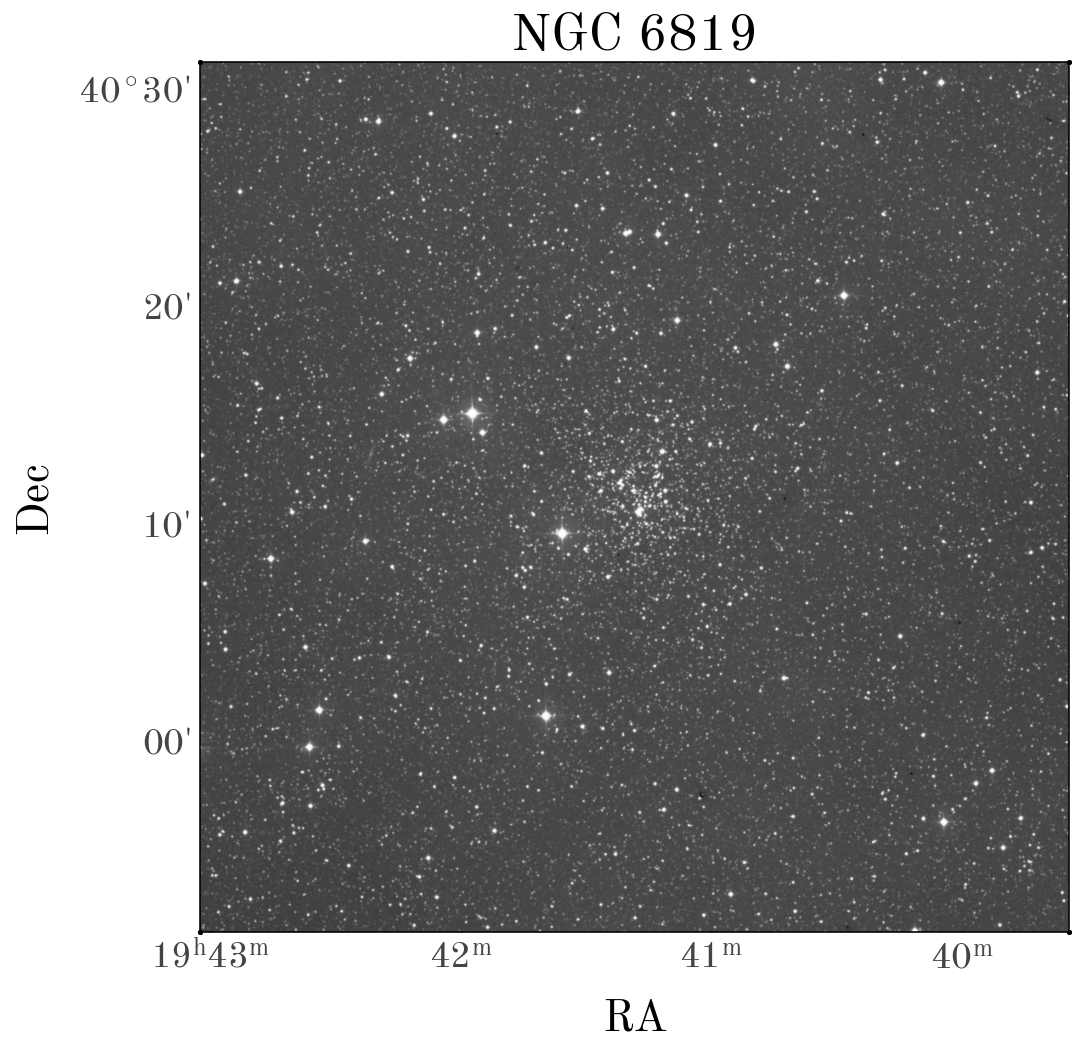

In [5]:
from astropy.io import fits
from astropy.wcs import WCS

hdul = fits.open("NGC6819-DSS-r.fits")
wcs = WCS(hdul[0].header)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=wcs))
ax.imshow(hdul[0].data, origin="lower", cmap="Greys_r")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.set_title("NGC 6819");

Load the Gaia data (see `Get-data.ipynb` notebook if you want to know how I queried and downloaded this data):

In [58]:
g = GaiaData("NGC6819-gaiadr3.fits.gz")
g = g[::10]

In [59]:
c = g.get_skycoord(distance=False)

In [165]:
init_r = 1 / g.parallax.to_value(u.mas)
init_r[init_r <= 0] = np.random.beta(2, 5, size=(init_r <= 0).sum()) * 2/0.2

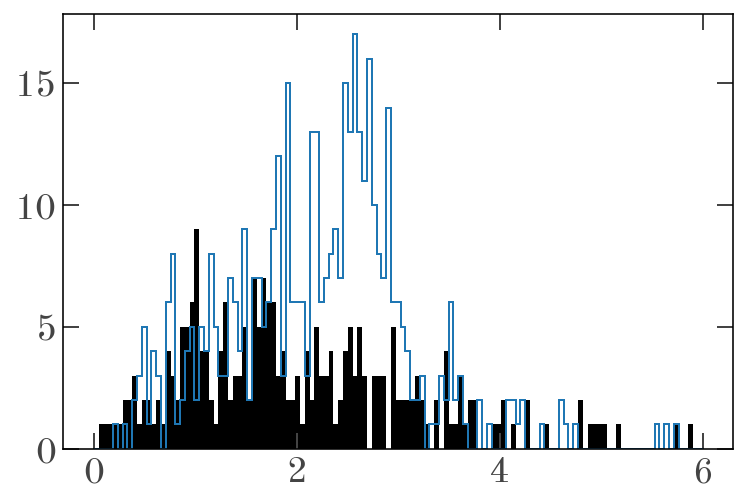

In [166]:
cluster_c = coord.SkyCoord.from_name("NGC 6819")
mask = c.separation(cluster_c) > (15 * u.arcmin)
# mask = c.separation(cluster_c) < (10*u.arcmin)

_bins = np.linspace(0, 6, 128)
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 5) & mask],
    bins=_bins,
);

plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 5) & ~mask],
    bins=_bins,
    histtype='step'
);

# plt.hist(
#     g.parallax.to_value(u.mas)[(g.parallax_over_error > 5) & mask],
#     bins=np.linspace(0.1, 0.7, 128)
# );

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_88448/3254036153.py:7: RuntimeWarning: divide by zero encountered in log
  return (2*np.log(r)) - 3*np.log(L) - np.log(2) - r/L


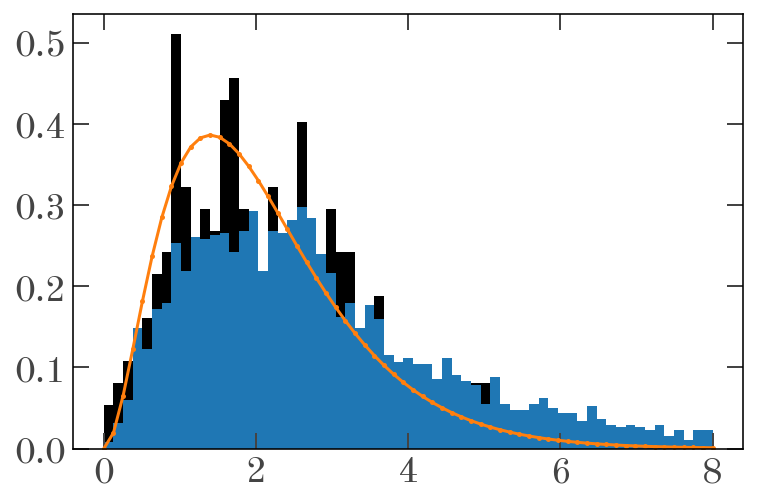

In [168]:
_bins = np.linspace(0, 8, 64)
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 4) & mask],
    bins=_bins,
    density=True
)
plt.hist(
    init_r,
    bins=_bins,
    density=True
)
plt.plot(_bins, np.exp(exp_dec_space_density_np(_bins, 0.7)))

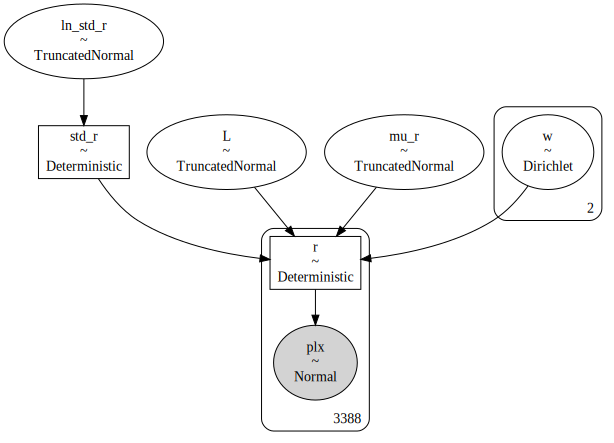

In [184]:
r_grid = np.linspace(1e-1, 10, 256)
with pm.Model() as cluster_model:
    # Prior set from literature values: https://en.wikipedia.org/wiki/NGC_6819
    mu_r = pm.TruncatedNormal("mu_r", mu=2.16, sigma=0.5, lower=0, initval=2.16)
    # ln_std_r = pm.Uniform("ln_std_r", -10, -1, initval=-6)
    ln_std_r = pm.TruncatedNormal("ln_std_r", -6, 5, lower=-10, upper=-1, initval=-6)
    std_r = pm.Deterministic("std_r", pm.math.exp(ln_std_r))

    # TODO:
    L = pm.TruncatedNormal("L", mu=1., sigma=2, lower=0, initval=1.)
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))
    dist1 = pm.TruncatedNormal.dist(mu_r, std_r, lower=0)
    # dist2 = pm.Bound.dist(pm.ChiSquared.dist(nu=6), lower=0)
    dist2 = pm.TruncatedNormal.dist(L, 1.5, lower=0)

    r = pm.Mixture(
        'r',
        w=w,
        comp_dists=[dist1, dist2],
        shape=len(g),
        initval=init_r
    )
    
    # mix_logp = pm.Deterministic('mix_logp', pm.logp(r, r_grid))
    
    pm.Normal(
        "plx",
        1 / r,
        observed=g.parallax.to_value(u.mas),
        sigma=g.parallax_error.to_value(u.mas),
        shape=len(g),
    )
    
pm.model_to_graphviz(cluster_model)

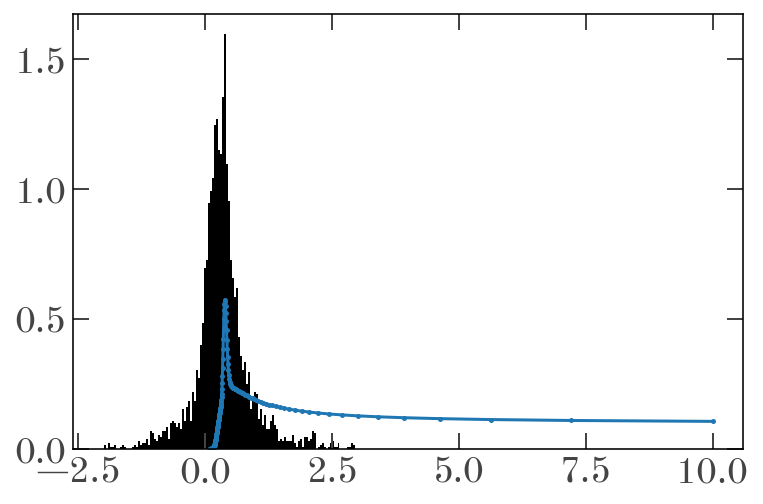

In [180]:
plx_bins = np.linspace(-2, 3, 128)
plt.hist(
    g.parallax.to_value(u.mas),
    bins=plx_bins,
    density=True
)

shit = cluster_model.compile_fn(mix_logp, inputs=[mu_r, ln_std_r, L, w])
plt.plot(1 / r_grid, np.exp(shit({'mu_r': 2.6, 'ln_std_r': -1.5, 'L': 2., 'w': [0.2, 0.8]})))

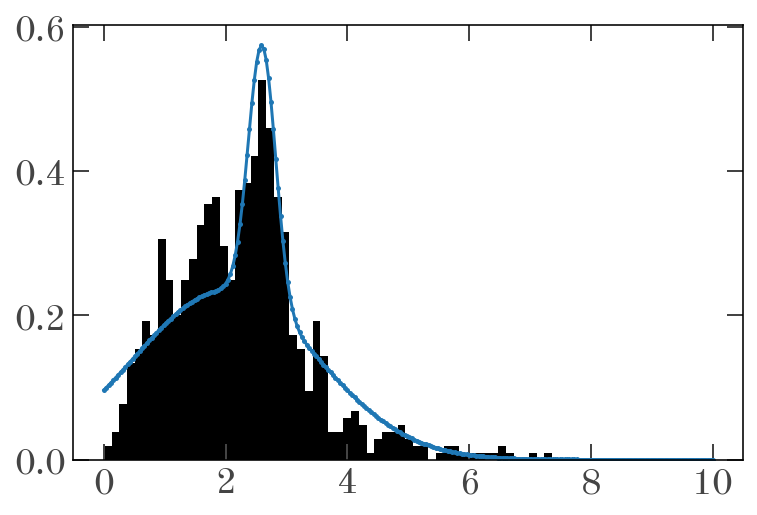

In [177]:
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 4)],
    bins=_bins,
    density=True
)

shit = cluster_model.compile_fn(mix_logp, inputs=[mu_r, ln_std_r, L, w])
plt.plot(r_grid, np.exp(shit({'mu_r': 2.6, 'ln_std_r': -1.5, 'L': 2., 'w': [0.2, 0.8]})))

In [181]:
with cluster_model:
    opt = pm.find_MAP(start={'mu_r': 2.6, 'ln_std_r': -1.5, 'L': 2., 'w': [0.2, 0.8], 'r': init_r})

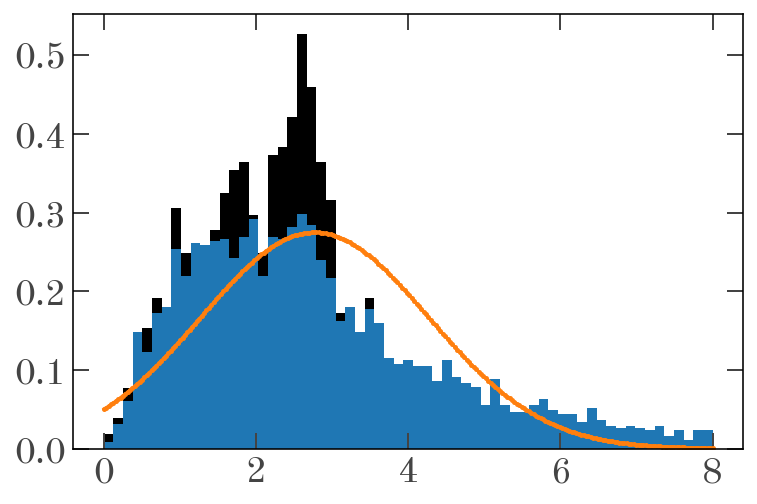

In [173]:
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 4)],
    bins=_bins,
    density=True
)
plt.hist(init_r, bins=_bins, density=True)

plt.plot(grid, np.exp(opt['mix_logp']))

In [51]:
with cluster_model:
    samples = pm.sample(start=opt)

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_88448/1685122262.py:2: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  opt = pm.sample(start=opt)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_r, ln_std_r, L, w, r]


/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19544 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target.

In [53]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_r,6.173,1.212,4.400,7.578,0.603,0.462,4.0,11.0,3.34
ln_std_r,-9.781,0.103,-9.889,-9.611,0.051,0.039,4.0,13.0,3.63
L,0.016,0.003,0.013,0.020,0.002,0.001,5.0,26.0,2.98
w[0],0.001,0.000,0.001,0.002,0.000,0.000,4.0,11.0,3.55
w[1],0.999,0.000,0.998,0.999,0.000,0.000,4.0,11.0,3.55
...,...,...,...,...,...,...,...,...,...
r[33869],4.191,1.559,1.673,5.609,0.777,0.595,4.0,14.0,3.26
r[33870],3.046,0.760,2.148,4.201,0.378,0.290,4.0,11.0,3.32
r[33871],3.191,0.180,2.966,3.481,0.089,0.068,5.0,12.0,3.10
r[33872],0.727,0.232,0.471,1.070,0.115,0.088,4.0,15.0,3.86


### Example: Cluster membership model with distance and proper motion

In [138]:
cluster_c = coord.SkyCoord.from_name("47 Tuc")
cluster_frame = coord.SkyOffsetFrame(origin=cluster_c)
c_cl = c.transform_to(cluster_frame)

In [143]:
other_mask = np.ones(len(g), dtype=bool)
for name in ["NGC 121", "ESO 28-19", "ESO 28-22", "Lindsay 14", "HW 5"]:
    other_c = coord.SkyCoord.from_name(name)
    other_mask &= c.separation(other_c) > 2 * u.arcmin

(-1.1, 1.1)

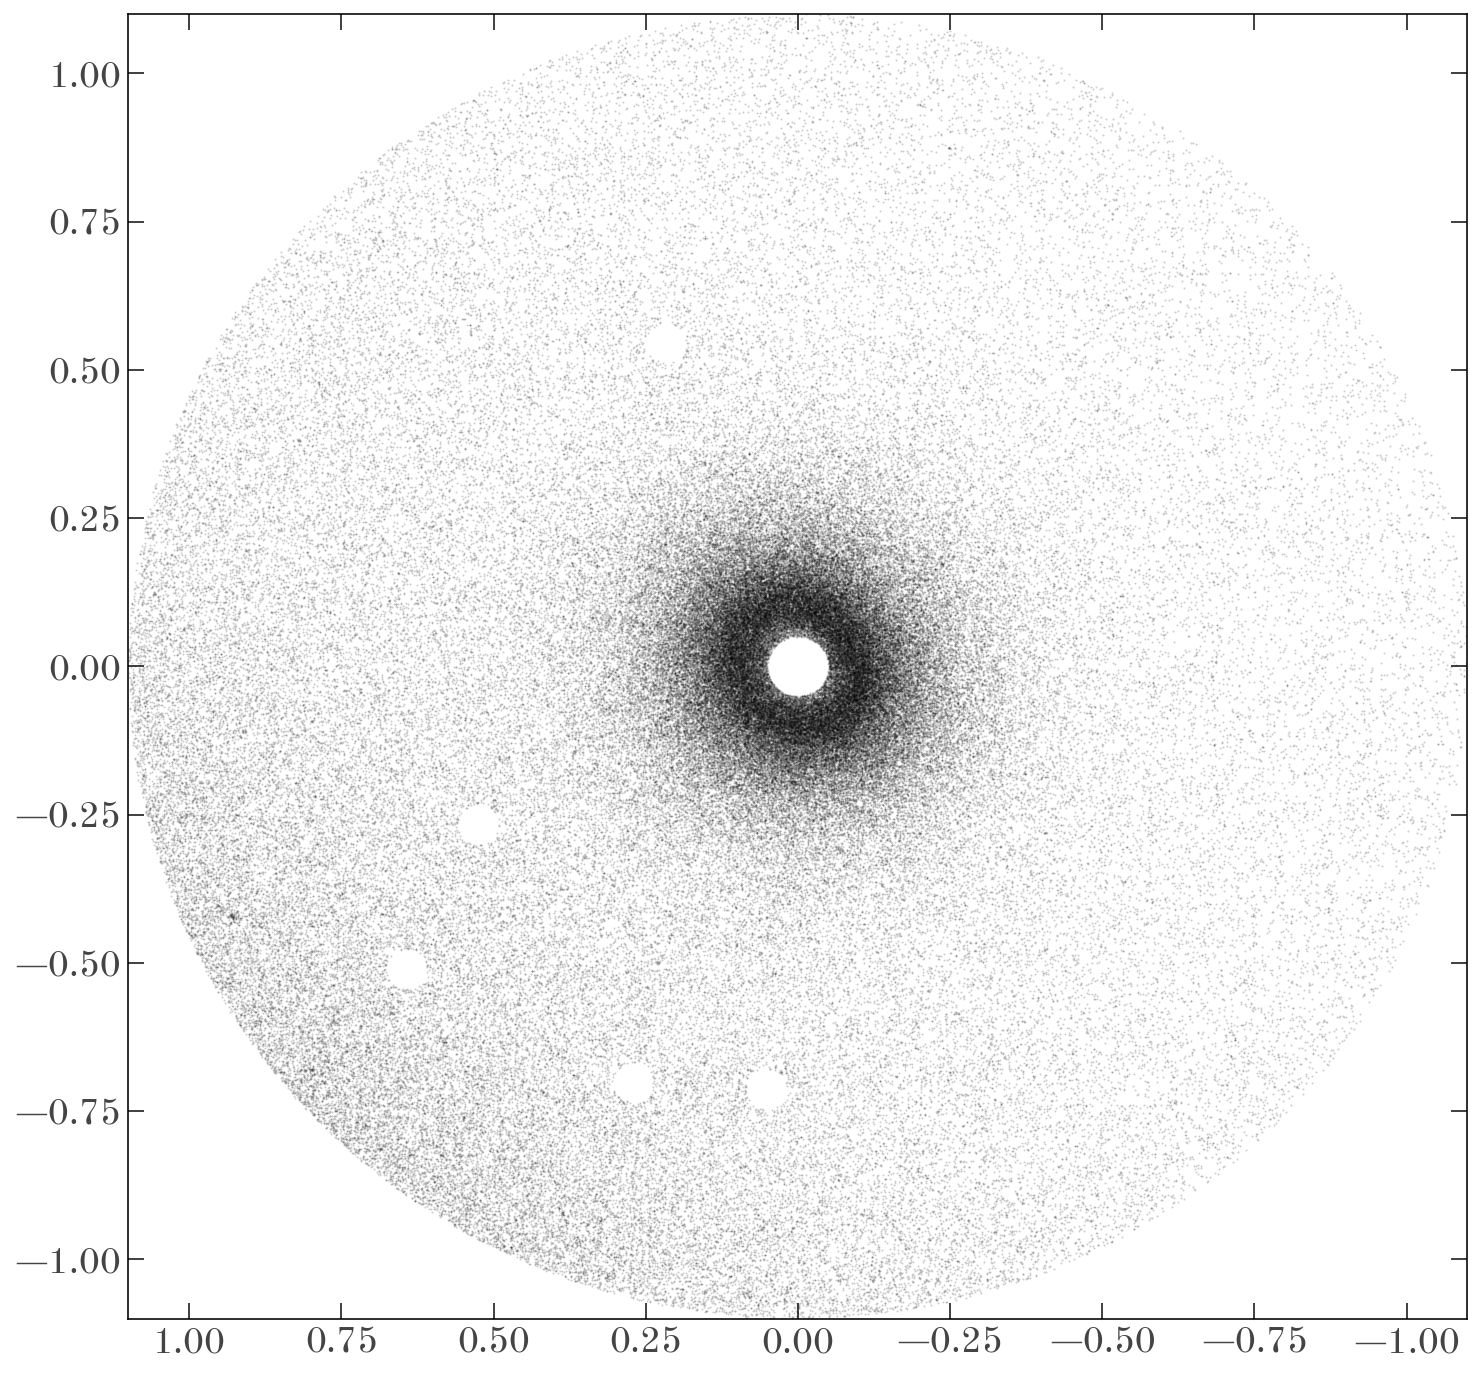

In [144]:
# fig, ax = plt.subplots(figsize=(6, 6))
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(
    c_cl.lon.degree[other_mask],
    c_cl.lat.degree[other_mask],
    marker="o",
    mew=0,
    ls="none",
    alpha=0.2,
    ms=1.0,
)
ax.set_xlim(1.1, -1.1)
ax.set_ylim(-1.1, 1.1)

In [146]:
cl_sky_mask = (
    (c.separation(cluster_c) < 0.25 * u.deg) & (c.separation(cluster_c) > 3 * u.arcmin)
) & other_mask
cl_area = np.pi * ((0.25 * u.deg) ** 2 - (3 * u.arcmin) ** 2)

no_cl_sky_mask = (
    (c.separation(cluster_c) > 1 * u.deg) & (c.separation(cluster_c) < 1.1 * u.deg)
) & other_mask
no_cl_area = np.pi * ((1.1 * u.deg) ** 2 - (1 * u.deg) ** 2)

cl_area, no_cl_area

(<Quantity 0.18849556 deg2>, <Quantity 0.65973446 deg2>)

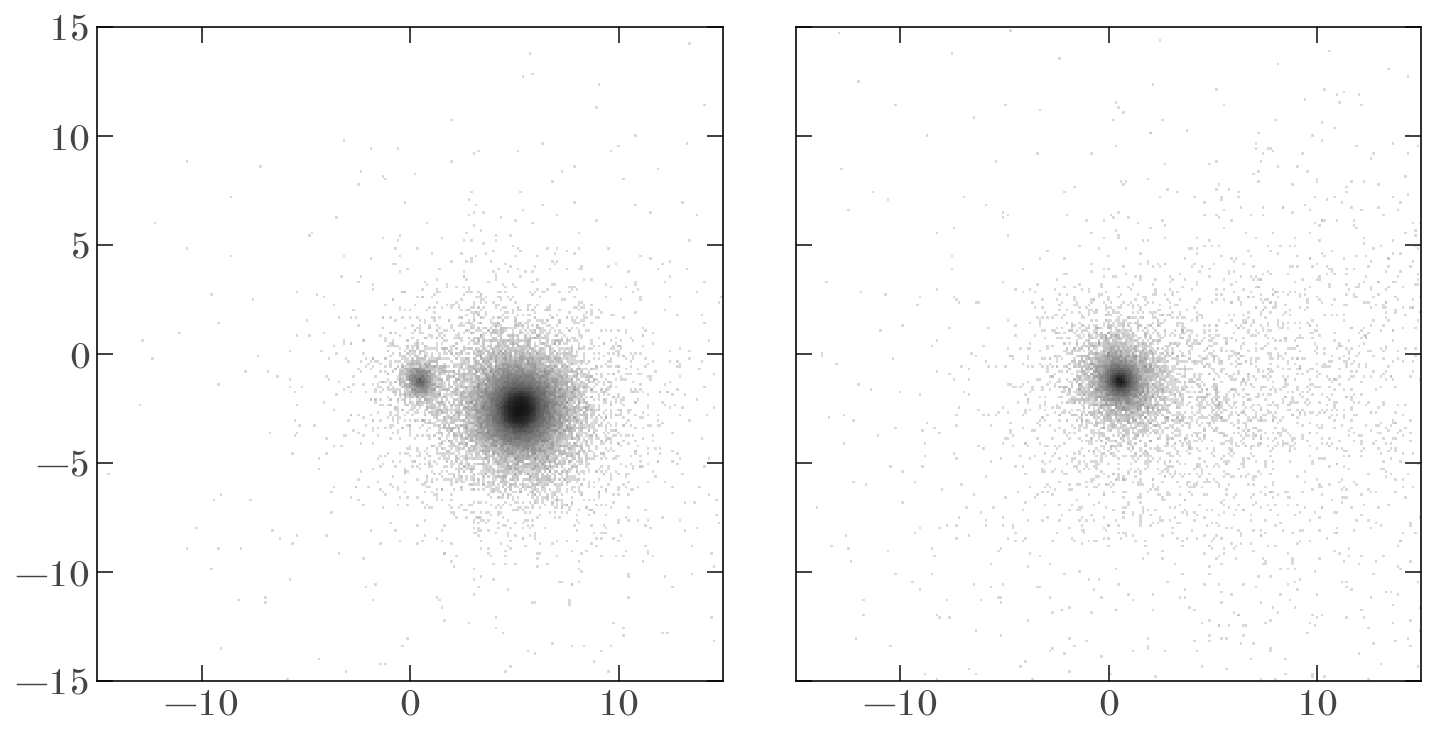

In [147]:
bins = np.linspace(-15, 15, 256)

fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)

ax = axes[0]
N = cl_sky_mask.sum()
ax.hist2d(
    c.pm_ra_cosdec.value[cl_sky_mask],
    c.pm_dec.value[cl_sky_mask],
    bins=bins,
    norm=mpl.colors.LogNorm(vmin=0.1, vmax=1e3),
    cmap="Greys",
)

ax = axes[1]
N = no_cl_sky_mask.sum()
ax.hist2d(
    c.pm_ra_cosdec.value[no_cl_sky_mask],
    c.pm_dec.value[no_cl_sky_mask],
    bins=bins,
    norm=mpl.colors.LogNorm(vmin=0.1, vmax=1e3),
    cmap="Greys",
);

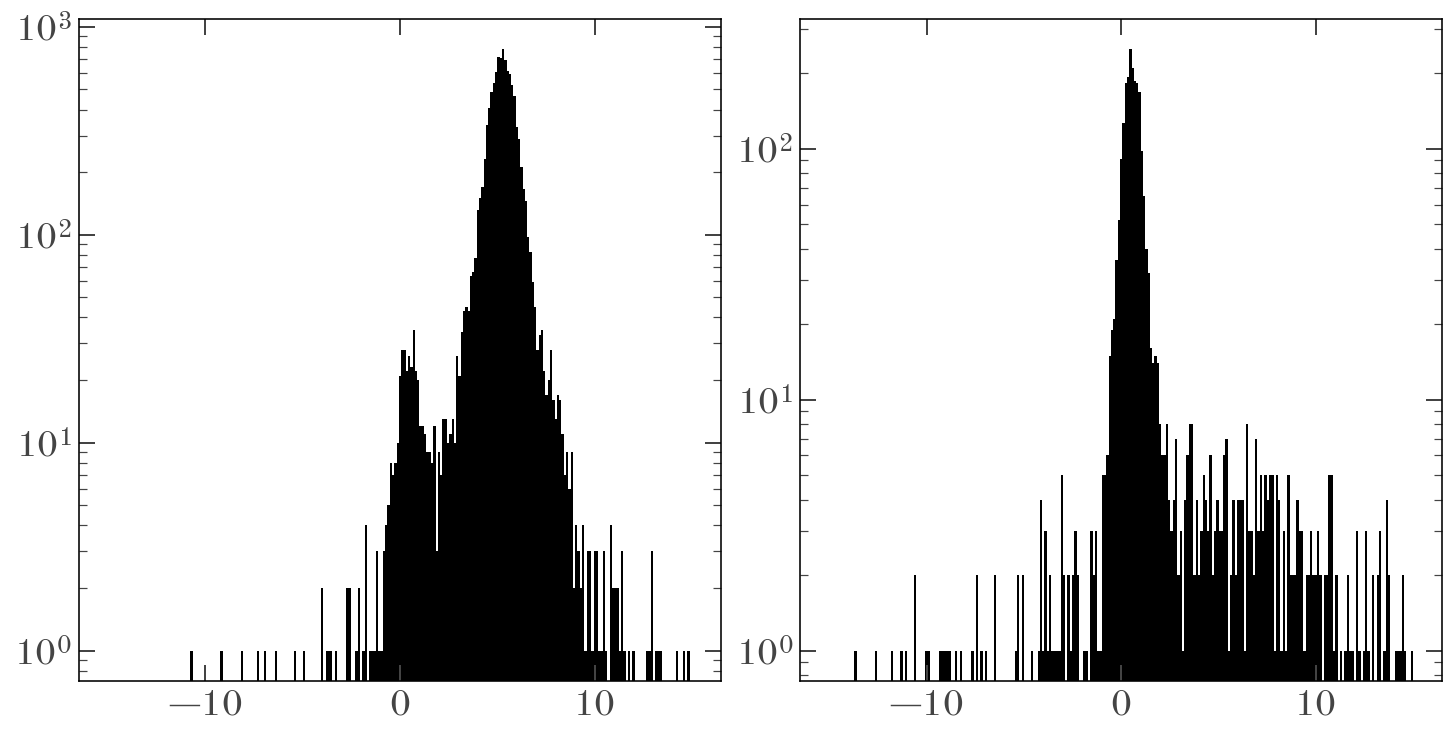

In [152]:
bins = np.linspace(-15, 15, 256)
# magmask = g.phot_g_mean_mag < 18.*u.mag
magmask = (g.phot_g_mean_mag > 19.5 * u.mag) & (g.phot_g_mean_mag < 20 * u.mag)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)

ax = axes[0]
ax.hist(
    c.pm_ra_cosdec.value[cl_sky_mask & magmask],
    bins=bins,
)
ax.set_yscale("log")

ax = axes[1]
ax.hist(
    c.pm_ra_cosdec.value[no_cl_sky_mask & magmask],
    bins=bins,
)
ax.set_yscale("log")

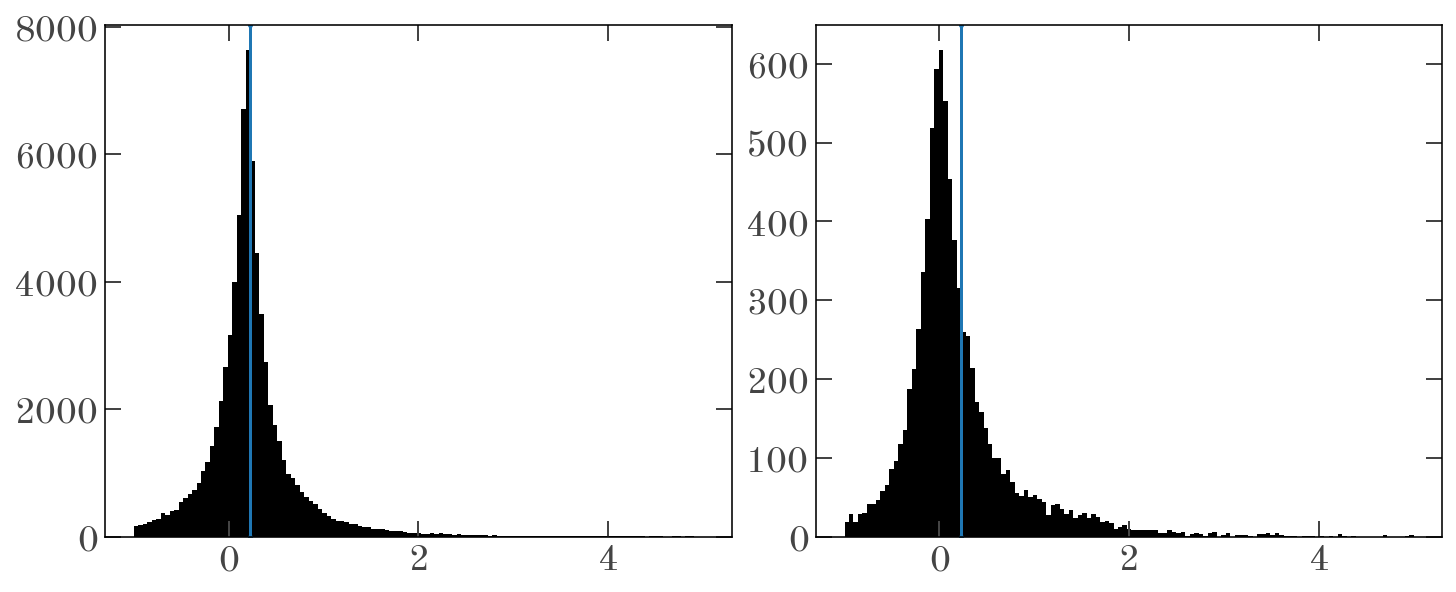

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, constrained_layout=True)

ax = axes[0]
ax.hist(
    g.parallax.value[cl_sky_mask],
    bins=np.linspace(-1, 5, 128),
)
ax.axvline(1 / 4.5, color="tab:blue")

ax = axes[1]
ax.hist(
    g.parallax.value[no_cl_sky_mask],
    bins=np.linspace(-1, 5, 128),
)
ax.axvline(1 / 4.5, color="tab:blue")

# ax.set_yscale('log')